In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel
from quetzal.io import excel
import os
import numpy as np
import pandas as pd
if manual:
    %matplotlib inline

SQLalchemy is not installed. No support for SQL output.


In [3]:
parameter_frame = pd.read_excel('../../inputs/parameters.xlsx')

In [4]:
parameter_frame.drop(['description', 'unit', 'by'], axis=1, errors='ignore', inplace=True)

# IN

In [5]:
training_folder = '../../'

In [6]:
sm = stepmodel.read_zippedpickles(training_folder + r'model/{scen}/networks'.format(scen='base'))
import geopandas as gpd
zones = gpd.read_file(r'../../inputs/zones/zones_name_and_sample.geojson')
zones.crs = {'init': 'epsg:4326'}
zones = zones.to_crs({'init': 'epsg:20137'})
sm.zones = zones

zone_to_transit: 100%|█████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 37.06it/s]


In [7]:
sm.zones.index = sm.zones['kebele_latin'].apply(lambda s: s.replace(' ', '_'))

In [8]:
boarding_time = 300

In [9]:
# the scenario specific variables are read from the parameter file
var = excel.read_var(file='../../inputs/parameters.xlsx', scenario=scenario)

In [10]:
import rasterio
import rasterio.plot

In [11]:
raster_50000 = rasterio.open(r'../../inputs/tiff/50000_base_20137.tif')
raster_25000 = rasterio.open(r'../../inputs/tiff/25000_base_20137.tif')
raster_100000 = rasterio.open(r'../../inputs/tiff/100000_base_20137.tif')

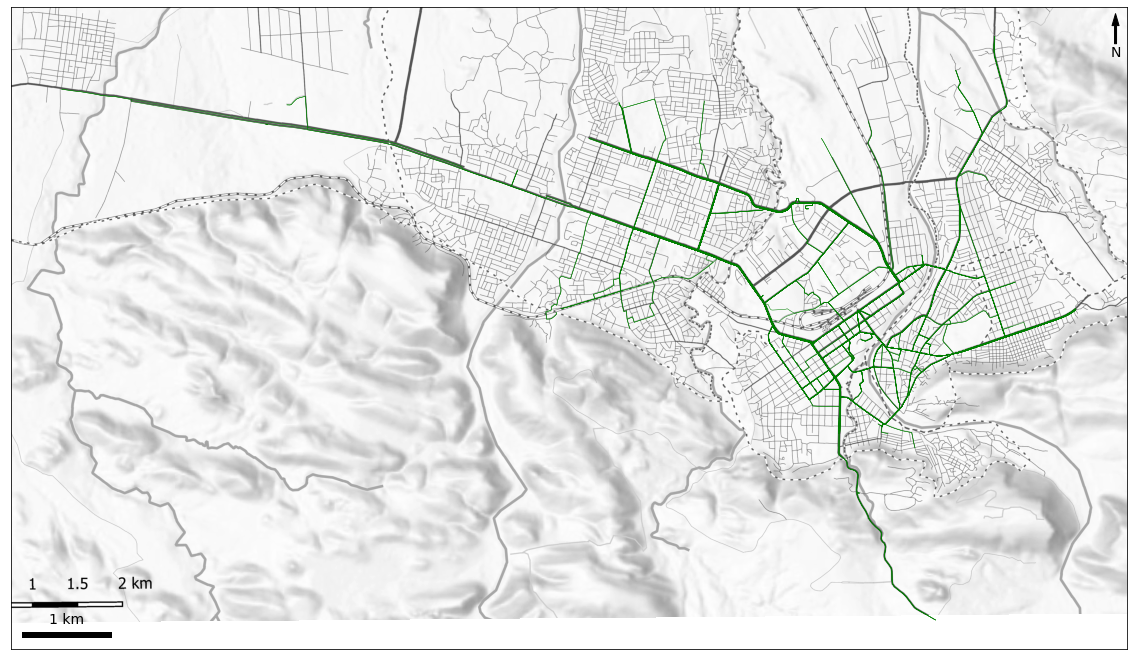

In [12]:
fontsize=14
if manual:
    ax = sm.plot(
        'links', basemap_url=None, figsize=[20, 20], color='green',
        basemap_raster=raster_50000, north_arrow=True, scalebar=True, linewidth=0.5)

# SPEED, HEADWAY AND FARE

In [13]:
sm.links['route_type'] = 'bajaj'

In [14]:
headway_dict = var['headway'].to_dict()
sm.links['headway'] = np.nan
sm.links['headway'].fillna(sm.links['route_type'].apply(lambda t: headway_dict.get(t, np.nan) ), inplace=True)

In [15]:
sm.links['length'] = sm.links['road_length']
sm.road_links['walk_speed'] = float(var['speed']['walk_on_road']) # km / h
sm.road_links['speed'] = float(var['speed']['car']) # km / h
sm.road_links['walk_time'] = sm.road_links['length'] / sm.road_links['walk_speed'] / 1000 * 3600

In [16]:
sm.road_links['time'] = sm.road_links['length'] / sm.road_links['speed'] / 1000 * 3600

In [17]:
for value in ['time', 'length']: 
    d = sm.road_links[value].to_dict()
    sm.links['road_' + value ] = sm.links['road_link_list'].apply(lambda l: sum(d[i] for i in l))
    
sm.links['time'] = sm.links['road_time'] / var['general']['bus_speed_factor']
sm.links['length'] = sm.links['road_length']

# WALKMODEL

In [18]:
sm = sm.change_epsg(epsg=20137, coordinates_unit='meter')

Reprojecting model from epsg 20137 to epsg 20137: 100%|████████████████████████████████| 33/33 [00:00<00:00, 67.45it/s]


In [19]:
kwargs = var['preparation_footpaths'].to_dict()
sm.preparation_footpaths(**kwargs)
print('preparation_footpaths:', kwargs)

kwargs = var['preparation_ntlegs'].to_dict()
sm.preparation_ntlegs(zone_to_road=True, zone_to_transit=True, **kwargs)
print('preparation_ntlegs:', kwargs)

sm.zone_to_transit['length'] = sm.zone_to_transit['geometry'].apply(lambda g: g.length)
sm.zone_to_transit['time'] = sm.zone_to_transit['length'] / sm.zone_to_transit['speed'] * 3600 / 1000

preparation_footpaths: {'max_length': 3000, 'n_clusters': 3000, 'speed': 3}
preparation_ntlegs: {'n_ntlegs': 5, 'max_ntleg_length': 5000, 'long_leg_speed': 3, 'short_leg_speed': 3, 'threshold': 2000}


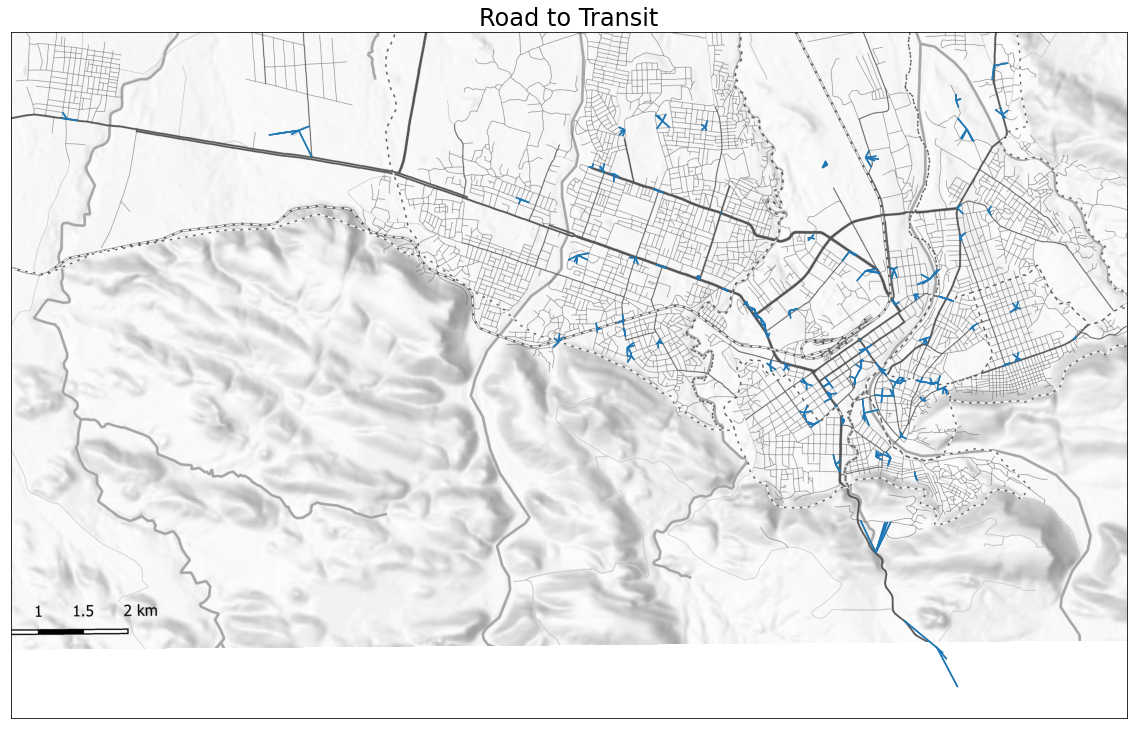

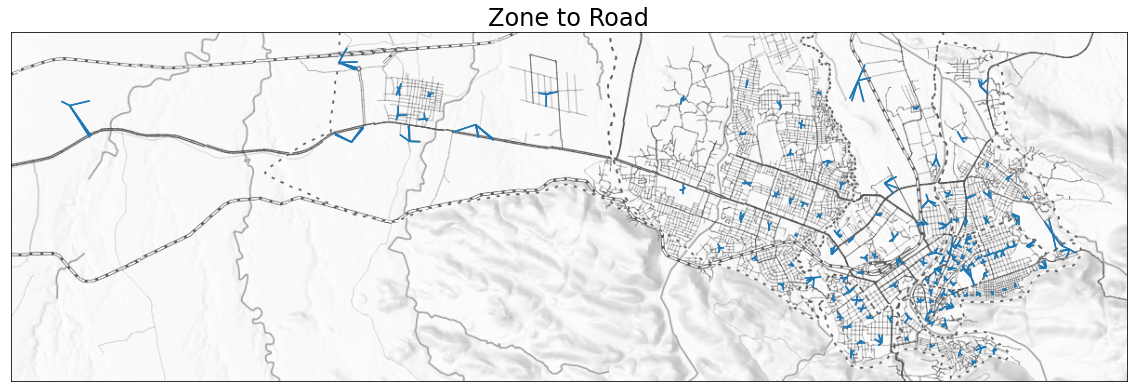

In [20]:
if manual:
    sm.plot('road_to_transit', figsize=[20, 20], basemap_raster=raster_50000, title='Road to Transit')
    sm.plot('zone_to_road', figsize=[20, 20], basemap_raster=raster_100000, title='Zone to Road')

In [21]:
sm._add_type_prefixes( prefixes={'links': 'link_', 'zone_to_road': 'ztr_','road_to_transit': 'rtt_'})
sm.zones = sm.zones.reindex(set(sm.zone_to_transit['a']).intersection(set(sm.zones.index)))
sm.zones = sm.zones.reindex(set(sm.zone_to_road['a']).intersection(set(sm.zones.index)))

# PT PATHFINDER
## WOR walk on road
people walk on the road network, slow computation

In [22]:
wor = sm.copy()
wor.footpaths = None
wor.zone_to_transit = None
wor.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=True, boarding_time=boarding_time)

path_analysis: 100%|██████████████████████████████████████████████████████████| 17689/17689 [00:00<00:00, 36411.99it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


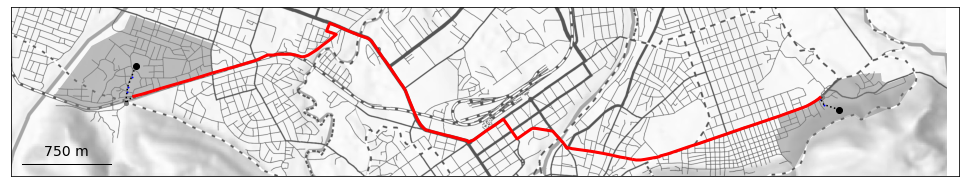

In [23]:
origin, destination ='k8_misrak_buna_board', 'k2_kebele_02' 
if manual:
    plot = wor.plot_separated_paths(
        origin, destination,
        basemap_raster=raster_50000, figsize=(17, 7), scalebar=True
    )

## ACF as the crow flies
people walk on dedicated access and egress links only

In [24]:
acf = sm.copy()
acf.step_pt_pathfinder(broken_modes=False, broken_routes=False, boarding_time=boarding_time)

path_analysis: 100%|██████████████████████████████████████████████████████████| 17689/17689 [00:00<00:00, 79502.88it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


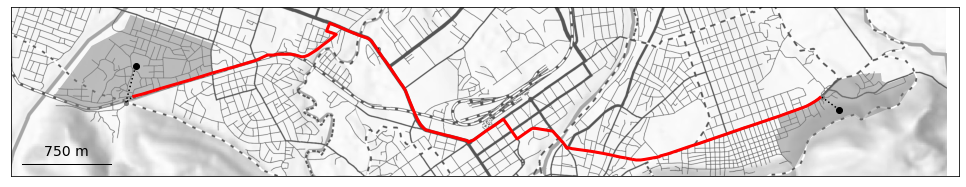

In [25]:
if manual:
    plot = acf.plot_separated_paths(
        origin, destination,
        basemap_raster=raster_50000, figsize=(17, 7), scalebar=True
    )

In [26]:
# here we chose to use the ACF or WOR paths
sm.pt_los = wor.pt_los

# OS optimal strategy

In [27]:
wor_os = sm.copy()
wor_os.step_strategy_finder(walk_on_road=True, boarding_time=boarding_time)

100%|████████████████████████████████████████████████████████████████████████████████| 133/133 [00:18<00:00,  7.17it/s]


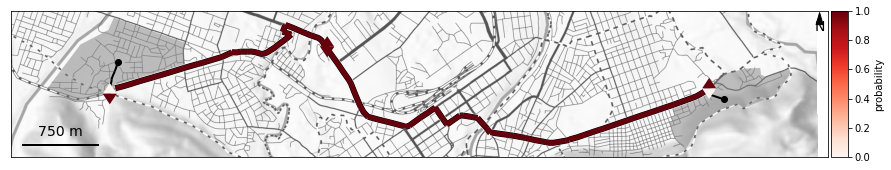

In [37]:
if manual:
    plot = wor_os.plot_strategy(
        origin, destination, road=True, cmap='Reds', ax=None , walk_on_road=True,
        figsize=(15, 10), legend='right', legend_kwds={'orientation': 'vertical', 'label': 'probability'},
        basemap_raster=raster_50000, scalebar=True, north_arrow=True
    )

In [38]:
acf_os = sm.copy()
acf_os.step_strategy_finder(walk_on_road=False, boarding_time=boarding_time)

100%|████████████████████████████████████████████████████████████████████████████████| 133/133 [00:06<00:00, 20.77it/s]


In [44]:
acf_os.zone_to_transit= gpd.GeoDataFrame(acf_os.zone_to_transit )

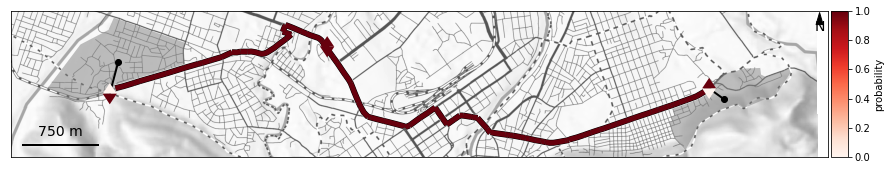

In [45]:
if manual:
    plot = acf_os.plot_strategy(
        origin, destination, road=True, cmap='Reds', ax=None, walk_on_road=False,
        figsize=(15, 10), legend='right', legend_kwds={'orientation': 'vertical', 'label': 'probability'},
        basemap_raster=raster_50000, scalebar=True, north_arrow=True
    )

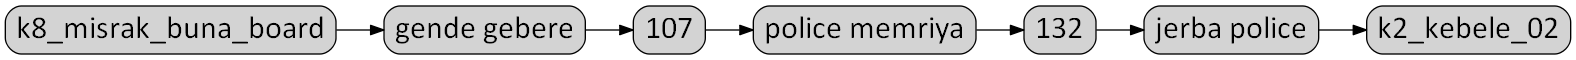

In [46]:
os.environ["PATH"] += os.pathsep + r'C:\Users\mgomezdelarosa\graphviz-2.38\release\bin/'
os.environ["PATH"] += os.pathsep + r'C:\Users\qchasserieau\dev\graphviz-2.38\release\bin/'
wor_os.display_aggregated_edges( origin, destination, ranksep=0.5,rankdir='LR', irrelevant_nodes=set(sm.road_nodes.index))

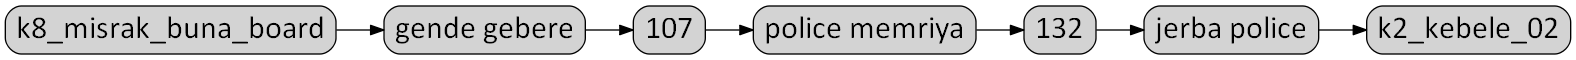

In [47]:
acf_os.display_aggregated_edges( origin, destination, ranksep=0.5,rankdir='LR', irrelevant_nodes=set(sm.road_nodes.index))

# ROAD PATHFINDER

In [48]:
sm.step_road_pathfinder(all_or_nothing=True)

In [49]:
sm.wor_pt_los = wor.pt_los
sm.acf_pt_los = acf.pt_los
sm.wor_os_pt_los = wor_os.pt_los
sm.acf_os_pt_los = acf_os.pt_los
sm.pt_los = sm.wor_os_pt_los

sm.optimal_strategy_nodes = wor_os.optimal_strategy_nodes
sm.optimal_strategy_sets = wor_os.optimal_strategy_sets
sm.optimal_strategy_edges = wor_os.optimal_strategy_edges

In [50]:
if not os.path.isdir(training_folder + 'model/{scen}'.format(scen=scenario)):
    os.mkdir(training_folder + "model/%s" % scenario)
sm.to_zippedpickles(training_folder + 'model/{scen}/aon_pathfinder'.format(scen=scenario))  

optimal_strategy_edges: 100%|██████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.72it/s]


# PLOT

<AxesSubplot:xlabel='gtime_x', ylabel='gtime_y'>

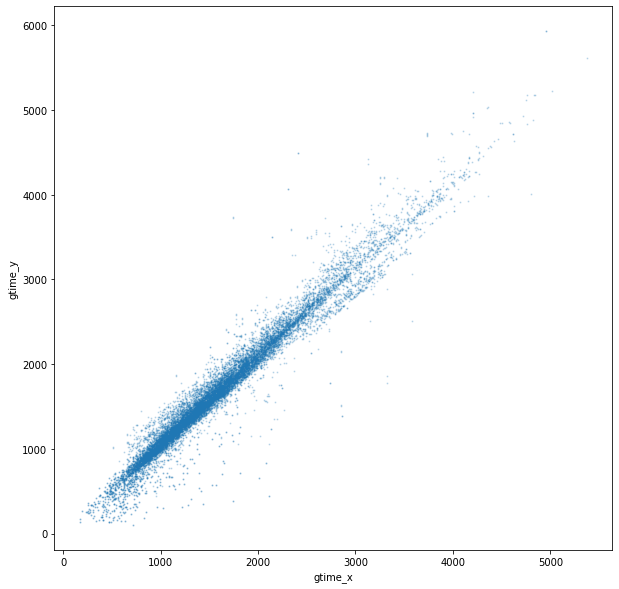

In [36]:
if manual:
    los = pd.merge(acf_os.pt_los, wor_os.pt_los, on=['origin', 'destination'])
    los = los.loc[los['origin'] != los['destination']]
    los.plot(kind='scatter', x='gtime_x', y='gtime_y', figsize=[10, 10], s=1, alpha=0.2)

In [ ]:
end_of_notebook